In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import glob
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import math
import random
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [3]:
audio_file_path="/content/drive/MyDrive/FYP 2023/AUG_Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

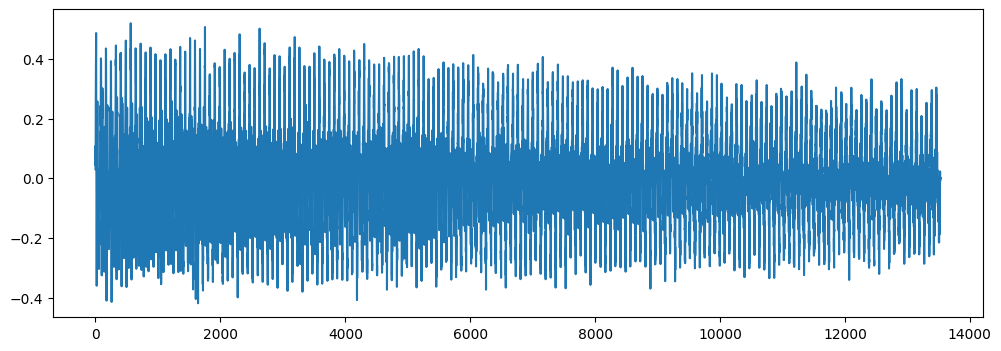

In [4]:
###plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)


In [5]:
def transformation(mfccs_feature):
  g = lambda x: math.sqrt(x) if x >= 0 else -math.sqrt(abs(x))
  f = np.vectorize(g)
  mfccs_feature_trans = f(mfccs_feature)
  return mfccs_feature_trans

In [23]:
def features_extractor_MFCC(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mfccs_features = transformation(mfccs_features)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [7]:
disphonie = 0
laryn = 0
heal = 0
def features_extractor_currect_folder(foldername,label):
  global disphonie, laryn, heal
  label_feature=[]
  for filename in tqdm(glob.glob(foldername+'/*.wav')):
    if label == 0:
      heal += 1
    elif label == 1:
      disphonie +=1
    elif label == 2:
      laryn += 1
    data=features_extractor_MFCC(filename)
    label_feature.append([data,label])
    # print((label_feature))
  return label_feature

In [25]:
hyper_disphonie = []
laryngitis = []
healthy = []
label_features = []
folder_path='/content/drive/MyDrive/FYP 2023/AUG_Dataset'
folder_path_2 = '/content/drive/MyDrive/FYP 2023/Dataset'
folders_labels = [
    (
        flder,
        0 if 'healthy' in flder[len(folder_path):] else
        1 if 'Dysphonie' in flder[len(folder_path):] else
        2 if 'laryngitis' in flder[len(folder_path):] else -1  # Default label if none match
    )
    for flder in glob.glob(folder_path + '/*') + glob.glob(folder_path_2 + '/*')
]
print(folders_labels)



import numpy as np
from scipy.stats import skew


def mfcc_skewness(foldername, label):
    mfccs_skewness = []
    for filename in tqdm(glob.glob(foldername + '/*.wav')):
        audio, sample_rate = librosa.load(filename)
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features = transformation(mfccs_features)
        # print(mfccs_features)
        mfccs_skewness.append(skew(mfccs_features, axis=None))
    return np.mean(mfccs_skewness)

skewness_dict = {}

for folder , label in (folders_labels):
  skewness = mfcc_skewness(folder, label)
  skewness_dict[label] = skewness
  label_features.extend(features_extractor_currect_folder(folder,label))
  # print(label_features)
  # break
print("skewness: ", skewness_dict)

[('/content/drive/MyDrive/FYP 2023/AUG_Dataset/female_healthy', 0), ('/content/drive/MyDrive/FYP 2023/AUG_Dataset/female_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/FYP 2023/AUG_Dataset/male_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/FYP 2023/AUG_Dataset/female_laryngitis', 2), ('/content/drive/MyDrive/FYP 2023/AUG_Dataset/male_laryngitis', 2), ('/content/drive/MyDrive/FYP 2023/AUG_Dataset/male_healthy', 0), ('/content/drive/MyDrive/FYP 2023/Dataset/female_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/FYP 2023/Dataset/female_laryngitis', 2), ('/content/drive/MyDrive/FYP 2023/Dataset/male_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/FYP 2023/Dataset/male_laryngitis', 2), ('/content/drive/MyDrive/FYP 2023/Dataset/female_healthy', 0), ('/content/drive/MyDrive/FYP 2023/Dataset/male_healthy', 0)]


100%|██████████| 448/448 [00:13<00:00, 32.22it/s]

skewness:  {0: -0.29202929608305317, 1: -0.21141321800026852, 2: -0.1849906223804348}


In [26]:
print(heal, laryn, disphonie)

5271 3741 5583


In [27]:
count = 0
for folder, label in (folders_labels):
  if label == -1:
    count = count + 1

print(count)

0


In [28]:
label_features_df=pd.DataFrame(label_features,columns=['feature','class'])
label_features_df = label_features_df.sample(frac=1, random_state=42)  # Set a random_state for reproducibility

# Reset the index if needed
label_features_df.reset_index(drop=True, inplace=True)

label_features_df.tail()

,feature,class
4860,"[-15.232805928856726, 13.559134338168123, -6.9...",0
4861,"[-11.577124604561394, 9.411720210761429, 0.694...",1
4862,"[-14.956691656447063, 8.677210261894016, 1.251...",1
4863,"[-13.9538688477048, 11.132739490722093, 5.3555...",2
4864,"[-9.669747877754181, 5.49916010639818, 4.99906...",1


In [29]:
path="/content/drive/MyDrive/FYP 2023/Dataset"
label_features_df.to_json(path+'processed_data_multiclass.json')
X=np.array(label_features_df['feature'].tolist())
Y=np.array(label_features_df['class'].tolist())

print(len(X[-1]))
print(X.shape,Y.shape)
# implementing train-test-split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=60)
print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)

40
(4865, 40) (4865,)
(3892, 40) (973, 40)
(3892,) (973,)


In [30]:
clf1 = RandomForestClassifier(n_estimators = 450, max_depth = 25, criterion="gini", oob_score=True, max_features= "sqrt", random_state=33)
clf1.fit(X_train, Y_train)
y_pred = clf1.predict(X_test)
print()
print(clf1.oob_score_)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, y_pred))
tree_depths = [estimator.tree_.max_depth for estimator in clf1.estimators_]

# # Print depths of each tree
# for i, depth in enumerate(tree_depths, start=1):
#     print(f"Tree {i} depth: {depth}")


0.5963514902363823
ACCURACY OF THE MODEL:  0.6104830421377184


In [31]:
clf2 = RandomForestClassifier(n_estimators = 450, max_depth = 25, criterion="entropy", random_state=33)
clf2.fit(X_train, Y_train)
y_pred = clf2.predict(X_test)
print()
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, y_pred))
tree_depths = [estimator.tree_.max_depth for estimator in clf2.estimators_]

# # Print depths of each tree
# for i, depth in enumerate(tree_depths, start=1):
#     print(f"Tree {i} depth: {depth}")


ACCURACY OF THE MODEL:  0.6073997944501541


In [32]:
clf3 = RandomForestClassifier(n_estimators = 450, max_depth = 25, criterion="log_loss", random_state=33)
clf3.fit(X_train, Y_train)
y_pred = clf3.predict(X_test)
print()
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, y_pred))
tree_depths = [estimator.tree_.max_depth for estimator in clf3.estimators_]

# # Print depths of each tree
# for i, depth in enumerate(tree_depths, start=1):
#     print(f"Tree {i} depth: {depth}")


ACCURACY OF THE MODEL:  0.6073997944501541


In [33]:
classifiers = []
for class_label in range(3):
    y_train_binary = (Y_train == class_label).astype(int)
    print(y_train_binary)
    rf_classifier = RandomForestClassifier(n_estimators=450, max_depth = 25, random_state=42, criterion = "entropy")
    rf_classifier.fit(X_train, y_train_binary)
    classifiers.append(rf_classifier)

y_pred_probs = np.zeros((len(X_test), 3))
for class_label, clf in enumerate(classifiers):
    y_pred_probs[:, class_label] = clf.predict_proba(X_test)[:, 1]


y_pred = np.argmax(y_pred_probs, axis=1)

print(y_pred)
accuracy = metrics.accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)


[0 1 0 ... 0 0 1]
[1 0 0 ... 1 1 0]
[0 0 1 ... 0 0 0]
[1 1 0 0 1 1 2 1 1 0 1 1 1 0 1 0 0 2 0 1 0 1 1 1 0 0 2 0 1 1 0 2 0 0 0 1 2
 0 0 2 2 1 1 1 0 1 2 1 1 0 2 1 1 1 0 0 1 2 2 1 1 0 0 0 1 1 0 1 1 0 0 0 2 0
 1 1 1 1 1 1 0 1 0 0 0 0 2 1 1 1 1 1 1 1 0 1 1 2 0 2 1 1 0 1 0 1 0 1 0 0 1
 0 1 1 1 0 1 0 0 1 0 1 2 1 0 0 1 1 0 0 1 1 1 1 1 1 0 2 0 1 2 1 0 1 1 2 0 0
 1 0 1 2 0 1 1 1 1 2 2 2 2 1 1 0 0 0 0 1 2 1 2 0 2 2 1 0 1 0 1 0 2 0 1 2 1
 0 1 2 1 0 0 0 2 2 0 0 1 0 2 0 2 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 2 0
 0 0 2 1 1 0 1 1 0 2 1 0 0 1 1 1 1 1 1 2 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1
 2 1 1 0 1 0 1 1 1 2 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 2 1 2 2 2 0 2 0 1 0 0
 0 0 2 0 0 0 1 1 1 0 0 2 1 0 0 1 0 0 1 0 1 0 2 2 1 1 2 0 2 0 0 1 0 2 0 0 1
 1 1 0 1 0 1 2 0 2 1 1 1 1 1 1 1 0 0 2 2 1 1 0 0 0 1 1 2 1 1 0 1 1 0 0 1 1
 1 1 0 1 0 0 2 1 0 1 0 0 1 0 0 1 2 1 1 1 0 0 1 0 1 0 2 0 0 1 1 2 1 1 0 2 0
 2 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 2 1 1 0 0 2 2 1 1 1 1 0 0 0 2 2 1 1 1
 1 1 1 1 2 0 0 1 2 1 1 1 0 1 0 0 1 0 0 1 0 1 1

In [34]:
folder_path = "/content/drive/MyDrive/FYP 2023/AUG_Dataset"
all_files = []
for root, dirs, files in os.walk(folder_path):
  for file in files:
    all_files.append(os.path.join(root, file))

if all_files:
    random_file = random.choice(all_files)
    print("Random file selected:", random_file)
else:
    print("No files found in the folder.")

if "healthy" in random_file:
  expected = 0
elif "laryngitis" in random_file:
  expected = 2
elif "Dysphonie" in random_file:
  expected = 1
audio, samplerate=librosa.load(random_file)
mfccs = librosa.feature.mfcc(y=audio, sr=samplerate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs.T,axis=0)
print(expected)
test_file = mfccs_scaled_features.reshape(1,40)
print(test_file.shape)

a =clf1.predict(test_file)
b= clf2.predict(test_file)
c = clf3.predict(test_file)
print(a,b,c)

Random file selected: /content/drive/MyDrive/FYP 2023/AUG_Dataset/female_healthy/35-i_n.wav
0
(1, 40)
[0] [1] [1]


In [35]:
scores1 = cross_val_score(clf1, X, Y, cv = 5)
print(scores1)
scores2 = cross_val_score(clf2, X, Y, cv = 5)
print(scores2)
scores3 = cross_val_score(clf3, X, Y, cv = 5)
print(scores3)

[0.60842754 0.61048304 0.63001028 0.60637205 0.6012333 ]
[0.59403905 0.5971223  0.61664954 0.61151079 0.60945529]
[0.59403905 0.5971223  0.61664954 0.61151079 0.60945529]


In [36]:
print(f"Mean Validation Score: {scores1.mean():.4f}")
print(f"Mean Validation Score: {scores2.mean():.4f}")
print(f"Mean Validation Score: {scores3.mean():.4f}")

Mean Validation Score: 0.6113
Mean Validation Score: 0.6058
Mean Validation Score: 0.6058


In [37]:
param_grid = {
    'n_estimators': [350, 400, 450, 500],
    'max_depth': [20, 25, 30]
}

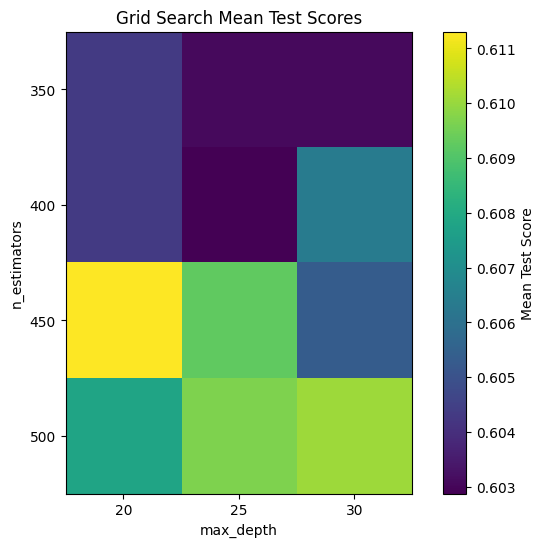

In [38]:
grid_search = GridSearchCV(clf1, param_grid, cv=5)
grid_search.fit(X, Y)

scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']))

# Visualize the effect of hyperparameters on model performance (heatmap)
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.colorbar(label='Mean Test Score')
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])
plt.yticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.title('Grid Search Mean Test Scores')
plt.show()

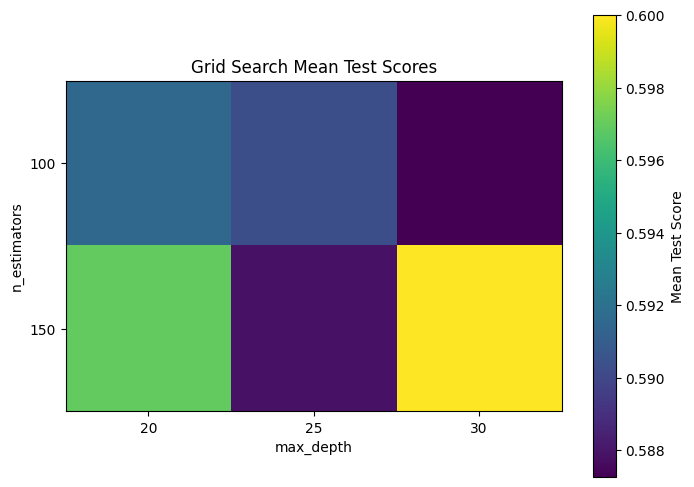

In [39]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [20, 25, 30]
}
grid_search = GridSearchCV(clf1, param_grid, cv=5)
grid_search.fit(X, Y)

scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']))

# Visualize the effect of hyperparameters on model performance (heatmap)
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.colorbar(label='Mean Test Score')
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])
plt.yticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.title('Grid Search Mean Test Scores')
plt.show()
